<a href="https://colab.research.google.com/github/Jang-KyungWuk/Slide_Puzzle_Analysis/blob/master/Last_Origin_Slide_Puzzle_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
base_dir='/content/gdrive/My Drive/'

In [ ]:
# Size Factor and Flag check
row_size=3 #m
column_size=3 #n

plot_distribution_chart=True # Plot chart when enabled
save_csv=False # Save result_db and possible_case as csv type when enabled
load_csv=True # Load result_db and possible_case from existing csv files

In [ ]:
# Import Libraries
import copy
import csv
import sys
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
#Define Functions
def Puzzle_size(m=3, n=3):
    """Puzzle_size(m,n)
    Define size of puzzle
    m : size of single row (default 3)
    n : size of single column (default 3)

    3 by 3 for example, puzzle will follow order of
    right-side keyboard number pad
    """
    piece_num=1
    result=[]
    for cursor1 in range (n):
        row=[]
        for cursor2 in range (m):
            row.append(piece_num)
            piece_num+=1
        result.insert(0,row)
    result[n-1][0]="B" # B stands for blank piece that used for slide
    return result

def Moveable(pos_y, pos_x):
    """Moveable(pos_y, pos_x)
    Find moveable position of blank piece when position of blank piece is given
    Blank piece's position = puzzle[pos_y][pos_x]
    """
    global row_size
    global column_size
    result=[]
    # Up, Left, Right, Down 4 case
    if 0<=pos_y-1<column_size and 0<=pos_x<row_size: # Up
        result.append((pos_y-1,pos_x))
    if 0<=pos_y<column_size and 0<=pos_x+1<row_size: # Right
        result.append((pos_y,pos_x+1))
    if 0<=pos_y+1<column_size and 0<=pos_x<row_size: # Down
        result.append((pos_y+1,pos_x))
    if 0<=pos_y<column_size and 0<=pos_x-1<row_size: # Left
        result.append((pos_y,pos_x-1))
    return result

In [ ]:
# Program starts from here

# Start simulating every possible state using A-Star
if load_csv!=True:

    complete=Puzzle_size(row_size, column_size) # Compeleted puzzle (starting point)
    puzzle=[complete,column_size-1,0]
    # current puzzle state / position of Blank / position of Blank / Mother_puzzle

    possible_case=[] # Stock all of the possible cases
    result_db=[]
    # [ [ [puzzle_case/moter_puzzle],[...],[...]] with same # of blank move]


    possible_case.append(puzzle[0])
    result_db.append([[puzzle[0],"M"]])

    most_moved_puzzles=[puzzle]


    while len(most_moved_puzzles) !=0:
        partial_result=[] # Puzzles with same # of blank move
        next_most_moved_puzzles=[] # List which will be next most_moved_puzzles

        # Select each puzzle state
        for previous_state_cursor in range(len(most_moved_puzzles)):
            selected_puzzle=copy.deepcopy(most_moved_puzzles[previous_state_cursor])

            # Find puzzle's next possible states
            possible_case_by_move=[]
            future_blank_positions=Moveable(selected_puzzle[1],selected_puzzle[2])

            # Select each next possible state and move blank piece
            for next_blank in future_blank_positions:
                next_puzzle=copy.deepcopy(selected_puzzle)
                next_puzzle[0][next_puzzle[1]][next_puzzle[2]],next_puzzle[0][next_blank[0]][next_blank[1]]=next_puzzle[0][next_blank[0]][next_blank[1]],next_puzzle[0][next_puzzle[1]][next_puzzle[2]]
                next_puzzle[1],next_puzzle[2]=next_blank[0],next_blank[1]

                # Check whether its already found state or not
                if next_puzzle[0] not in possible_case:
                    possible_case.append(next_puzzle[0])
                    partial_result.append([next_puzzle[0],previous_state_cursor])
                    next_most_moved_puzzles.append(next_puzzle)

        # After finding next cases are done find future state from this case
        most_moved_puzzles=next_most_moved_puzzles
        result_db.append(partial_result) 

    # Final partial result is blank so delete that
    result_db.remove(result_db[-1])

# When load_csv == True (when dataset exists)
else:
    csv.field_size_limit(sys.maxsize)

    result_db=[]
    with open(base_dir+'Result_DB.csv',newline='') as file:
        reader=csv.reader(file)
        for row1 in reader:
            for row2 in row1:
                result_db.append(row2)
                
    possible_case=[]
    with open(base_dir+'Possible_case.csv',newline='') as file:
        reader=csv.reader(file)
        for row1 in reader:
            for row2 in row1:
                possible_case.append(row2)

    
    # Resurrect list in list structure
    result_db_res=[]
    possible_case_res=[]

    res_counter_limit=(row_size*column_size)+1

    # Resurrect result_db
    for step in range (len(result_db)):
        step_layer=[]
        db_layer=result_db[step]

        package=[]
        res_counter=0
        continuity=0

        for letter in db_layer:
            if letter not in ([' ',',','[',']',"'"]):
                package.append(letter)
                res_counter+=1
                continuity+=1

                if continuity>1:
                    package[-1]=package[-2]+package.pop(-1)
                    res_counter-=1
            else:
                continuity=0

            if res_counter==res_counter_limit and continuity==0:

                package_cursor=0
                structure=[]
                puzzle_grid=[]
                for column_cursor in range (column_size):
                    row=[]
                    for row_cursor in range (row_size):
                        try:
                            row.append(int(package[package_cursor]))
                        except:
                            row.append(package[package_cursor])
                        package_cursor+=1
                    puzzle_grid.append(row)
                        
                structure.append(puzzle_grid)
                try:
                    structure.append(int(package[package_cursor]))
                except:
                    structure.append(package[package_cursor])

                step_layer.append(structure)

                package=[]
                res_counter=0

        result_db_res.append(step_layer)
    result_db=result_db_res

    #Resurrect possible_case
    for str_puzzle in possible_case:
        package=[]
        for letter in str_puzzle:
            if letter not in ([' ',',','[',']',"'"]):
                package.append(letter)

        package_cursor=0
        puzzle_grid=[]
        for column_cursor in range (column_size):
            row=[]
            for row_cursor in range (row_size):
                try:
                    row.append(int(package[package_cursor]))
                except:
                    row.append(package[package_cursor])
                package_cursor+=1
            puzzle_grid.append(row)
        possible_case_res.append(puzzle_grid)

    possible_case=possible_case_res

# 새 섹션

In [ ]:
# This is total possible case of given condition slide puzzle
total_case=len(possible_case)

# Print the result
print(row_size,"by",column_size,"sized slide puzzle has",total_case,"possible cases")
print("Most complicated case requires at least",len(result_db)-1,"moves")

3 by 3 sized slide puzzle has 181440 possible cases
Most complicated case requires at least 31 moves


In [ ]:
# Save datas as csv file
if save_csv==True:
    with open(base_dir+"Result_DB.csv",'w',newline='') as myfile:
        wr=csv.writer(myfile, quoting=csv.QUOTE_ALL)
        wr.writerow(result_db)
    with open(base_dir+"Possible_case.csv",'w',newline='') as myfile:
        wr=csv.writer(myfile, quoting=csv.QUOTE_ALL)
        wr.writerow(possible_case)

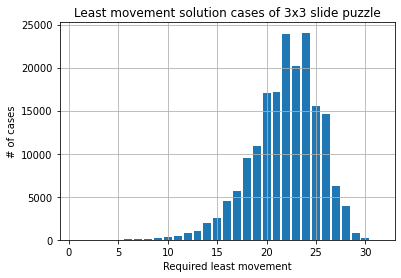

In [ ]:
# Plotting distribution bar chart
x=range (1,len(result_db))
y=[]
for moves in x:
    y.append(len(result_db[moves]))

if plot_distribution_chart==True:
    plt.bar(x,y)
    plt.xlabel("Required least movement")
    plt.ylabel("# of cases")
    plt.title("Least movement solution cases of "+str(row_size)+"x"+str(column_size)+" slide puzzle")
    plt.grid(True)
    plt.show()

In [ ]:
# Average movement required
total_moves=0
for moves in x:
    total_moves+=len(result_db[moves])*moves
average_movement_required=total_moves/total_case
print("Average movement required is",average_movement_required)

Average movement required is 21.972398589065257


In [ ]:
# Functions defined under this comment can be used for further analysis

def Counter(puzzle):
    """Counter(puzzle)
    input puzzle like "789456B12" or multiple puzzles using list
    function will return least required movment
    """
    global row_size #m
    global column_size #n

    global possible_case
    global y

    # If single case is given
    
    if type(puzzle)==str:
        # make str as slide puzzle grid form
        target=[]
        letter_cursor=0
        for cursor1 in range (column_size):
            row=[]
            for cursor2 in range (row_size):
                try:
                    row.append(int(puzzle[letter_cursor]))
                except:
                    row.append(puzzle[letter_cursor])
                letter_cursor+=1
            target.append(row)

        # y has distribution information
        # Find target index and because possible_case has data ordered by minimum required movement
        # So with distribution data, target's minimum required movement can be calculated
        case_index=possible_case.index(target)
        cumulative_distribution=0
        distribution_cursor=0
        while case_index > cumulative_distribution:
            cumulative_distribution+=y[distribution_cursor]
            distribution_cursor+=1
        return distribution_cursor
    
    # If multiple cases are given
    # Same as single str type data are given but doing it repeatitive
    # This feature doesn't needed
    '''
    else:
        result=[]
        for single_puzzle in puzzle:
            # make str as slide puzzle grid form
            target=[]
            letter_cursor=0
            for cursor1 in range (column_size):
                row=[]
                for cursor2 in range (row_size):
                    try:
                        row.append(int(single_puzzle[letter_cursor]))
                    except:
                        row.append(single_puzzle[letter_cursor])
                    letter_cursor+=1
                target.append(row)

            # y has distribution information
            # Find target index and because possible_case has data ordered by minimum required movement
            # So with distribution data, target's minimum required movement can be calculated
            case_index=possible_case.index(target)
            cumulative_distribution=0
            distribution_cursor=0
            while case_index > cumulative_distribution:
                cumulative_distribution+=y[distribution_cursor]
                distribution_cursor+=1
            result.append(distribution_cursor)
        return result
    '''
            

def Path_finder(puzzle):
    """Path_finder(puzzle)
    input puzzle like "789456B12"
    will return cases that will lead to complete puzzle
    """
    # Get parameters and result from outside of function
    global row_size #m
    global column_size #n

    global possible_case
    global y

    global result_db
    
    # make str as slide puzzle grid form
    target=[]
    letter_cursor=0
    for cursor1 in range (column_size):
        row=[]
        for cursor2 in range (row_size):
            try:
                row.append(int(puzzle[letter_cursor]))
            except:
                row.append(puzzle[letter_cursor])
            letter_cursor+=1
        target.append(row)

    
    case_index=possible_case.index(target)
    
    cumulative_distribution=0
    distribution_cursor=0

    # If only it is not 0 which means if given puzzle is not completed puzzle
    if case_index!=0:
        
        # case_index = 1 (Solved puzzle) + y[0] + y[1] + ... + y[n] + coordinate
        # While state loops until y[n+1]
        while case_index > cumulative_distribution:
            cumulative_distribution+=y[distribution_cursor]
            distribution_cursor+=1
        # y[n+1] value should not be included
        cumulative_distribution-=y[distribution_cursor-1]

        # Completed (Solved puzzle) Case
        cumulative_distribution+=1

 
    # This is cooridnate of puzzle case in result_db
    # result_db[mother_state_dimension][mother_state_cursor]
    mother_state_dimension=distribution_cursor
    mother_state_cursor=case_index-cumulative_distribution # to get coordinate only

    # This list will stack solution of given puzzle case
    solution=[]

    # Append puzzle step by step
    # In result_db, each puzzle case has coordinate of their mother-case
    # So by rewinding steps, this function can show solution
    while mother_state_dimension>=0:
        solution.append(result_db[mother_state_dimension][mother_state_cursor][0])
        mother_state_cursor=result_db[mother_state_dimension][mother_state_cursor][1]
        mother_state_dimension-=1
    return solution

In [ ]:
# Function under this comment can be used to find letter "B" which stands for Blank
# But above program now saves B's position so this function has no use
'''
def Blank_finder(puzzle):
    """Blank_finder(puzzle)
    Find letter "B" in the grid
    """
    global row_size
    global column_size
    for cursor_x in range (column_size):
        for cursor_y in range (row_size):
            if puzzle[cursor_x][cursor_y]=="B":
                return cursor_x,cursor_y
'''


'\ndef Blank_finder(puzzle):\n    """Blank_finder(puzzle)\n    Find letter "B" in the grid\n    """\n    global row_size\n    global column_size\n    for cursor_x in range (column_size):\n        for cursor_y in range (row_size):\n            if puzzle[cursor_x][cursor_y]=="B":\n                return cursor_x,cursor_y\n'

In [ ]:
# Get samples data from in-game data
# Data has column of puzzle number and column of puzzle pattern
# Values have str type and utf-8-sig encoded
# Google colab enviornment requires mounted drive
# A Star generated puzzle and samples puzzle should have same size
with open (base_dir+"samples.csv",newline='',encoding='utf-8-sig') as file:
  reader=csv.reader(file)
  samples=list(reader)
print(samples)

[['6', 'B73849265'], ['3', '95638B247'], ['1', '783925B64'], ['4', 'B83725964'], ['5', '9384B5267'], ['1', '4539286B7'], ['6', '4B5963728'], ['3', '73984B265'], ['1', '6759482B3'], ['3', '95B386247'], ['5', '438B95627'], ['5', '75B698243'], ['5', '38549762B'], ['3', '7B8953624'], ['2', '465938B72'], ['3', 'B35469728'], ['3', '9384B5267'], ['1', '6584B3972'], ['5', '873B95426'], ['6', '385497B62'], ['5', '945623B78'], ['3', '6584B3972'], ['4', '9B6358247'], ['4', '4539286B7'], ['2', '3594B6728'], ['3', '7839256B4'], ['1', '87349526B'], ['1', '9854372B6'], ['3', '95B386247'], ['6', '65847392B'], ['2', '8734B9265'], ['2', '39625847B'], ['2', 'B45923678'], ['1', '43895B627'], ['6', '75B698243'], ['3', '9853B6247'], ['5', '7839256B4'], ['4', '359426B78'], ['2', '7839256B4'], ['6', '73984B265'], ['2', '87349526B'], ['3', '9854372B6'], ['6', 'B35469728'], ['1', '945B63728'], ['4', '7B8953624'], ['4', '38B495627'], ['4', 'B38495627'], ['5', '783925B64'], ['3', '45392867B'], ['1', '46593B728'],

In [ ]:
# Check samples length (80)
print("From sample file,",len(samples),"samples were loaded")

From sample file, 500 samples were loaded


In [ ]:
# Distribute puzzle number column and puzzle type column
samples_num=[]
samples_type=[]
for n in range (len(samples)):
  samples_num.append(samples[n][0])
  samples_type.append(samples[n][1])

In [ ]:
puzzle_num_count=6 # Last Origin's case = 6

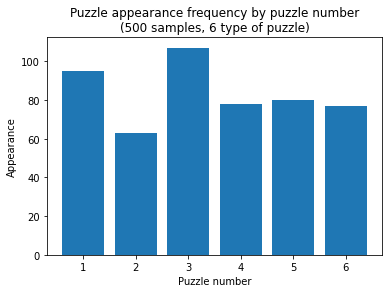

In [ ]:
# Puzzle appearance freequency (ratio) by puzzle number

puzzle_frequency_x=range(1,puzzle_num_count+1) # Last origin has 6 type of puzzle
puzzle_frequency_y=[]

for puzzle_num in (puzzle_frequency_x):
  puzzle_frequency_y.append(samples_num.count(str(puzzle_num)))

plt.bar(puzzle_frequency_x,puzzle_frequency_y)
plt.xlabel("Puzzle number")
plt.ylabel("Appearance")
plt.title("Puzzle appearance frequency by puzzle number\n("+str(len(samples))+" samples, "+str(puzzle_num_count)+" type of puzzle)")
plt.show()

In [ ]:
# Checking all puzzles are classified (This sholud return same value as samples amount)
sum(puzzle_frequency_y)

500

Observed pattern types are 80 patterns


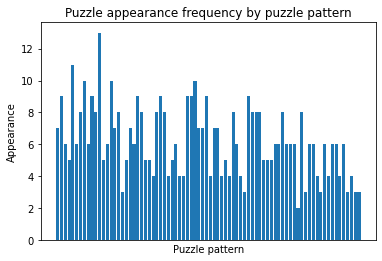

In [ ]:
# Puzzle appearance frequency (ratio) by puzzle pattern (shuffled puzzle)
pattern_type_x=[]
pattern_type_y=[]
for puzzle_pattern in range(len(samples_type)):
  if samples_type[puzzle_pattern] not in pattern_type_x:
    pattern_type_x.append(samples_type[puzzle_pattern])
    pattern_type_y.append(samples_type.count(samples_type[puzzle_pattern]))

print("Observed pattern types are",len(pattern_type_x),"patterns")

plt.bar(pattern_type_x,pattern_type_y)
plt.gca().axes.get_xaxis().set_ticks([])
plt.xlabel("Puzzle pattern")
plt.ylabel("Appearance")
plt.title("Puzzle appearance frequency by puzzle pattern")
plt.show()

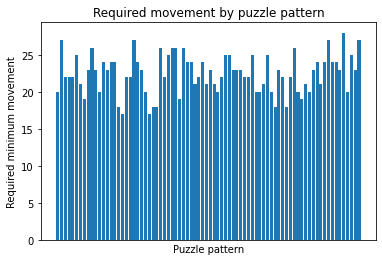

Average minimum required movement is 22.4875


In [ ]:
# Show each patterns required minimum movement to clear puzzle

pattern_clear_y=[]
for pattern in pattern_type_x:
  pattern_clear_y.append(Counter(pattern))
plt.bar(pattern_type_x,pattern_clear_y)
plt.gca().axes.get_xaxis().set_ticks([])
plt.xlabel("Puzzle pattern")
plt.ylabel("Required minimum movement")
plt.title("Required movement by puzzle pattern")
plt.show()

print("Average minimum required movement is",np.average(pattern_clear_y))

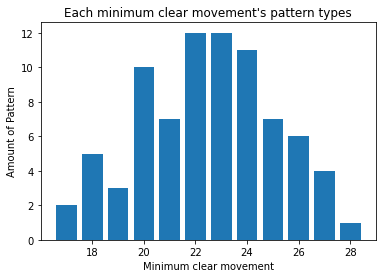

In [ ]:
# Show pattern ratio by required minimum movement
pattern_clear_frequency_y=[]
pattern_clear_frequency_x=range(min(pattern_clear_y),max(pattern_clear_y)+1)

for minimum_movement in pattern_clear_frequency_x:
  pattern_clear_frequency_y.append(pattern_clear_y.count(minimum_movement))
plt.bar(pattern_clear_frequency_x,pattern_clear_frequency_y)
plt.xlabel("Minimum clear movement")
plt.ylabel("Amount of Pattern")
plt.title("Each minimum clear movement's pattern types")
plt.show()

500


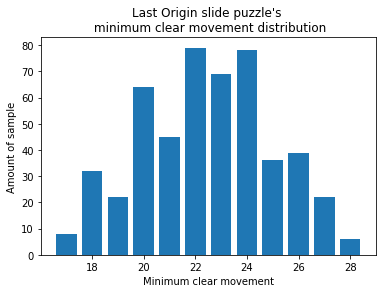

In [ ]:
# Sample distribution by minimum clear movement

sample_distribution=np.zeros(len(pattern_clear_frequency_x),dtype="int")
base=min(pattern_clear_frequency_x)

for sample in samples_type:
  sample_distribution[Counter(sample)-base]+=1

print(sum(sample_distribution))

plt.bar(pattern_clear_frequency_x,sample_distribution)
plt.xlabel("Minimum clear movement")
plt.ylabel("Amount of sample")
plt.title("Last Origin slide puzzle's \n minimum clear movement distribution")
plt.show()

In [ ]:
# With each patterns appearance probability, calculate average required minimum movement in last origin slide puzzle
total_required_minimum_movement=0
for cursor in range (len(pattern_type_y)):
  total_required_minimum_movement+=(pattern_type_y[cursor]*pattern_clear_y[cursor])
last_origin_average_required_minimum_movement=total_required_minimum_movement/len(samples)
print("Last Origin slide puzzle's average required minimum movement is",last_origin_average_required_minimum_movement)


Last Origin slide puzzle's average required minimum movement is 22.456


In [ ]:
# Classifiy puzzles by puzzle number

pattern_classified=[[],[],[],[],[],[]]

for cursor in range (len(samples)):
    pattern_classified[int(samples[cursor][0])-1].append(samples[cursor][1])

Puzzle 1 has 60 patterns
Puzzle 2 has 44 patterns
Puzzle 3 has 57 patterns
Puzzle 4 has 52 patterns
Puzzle 5 has 50 patterns
Puzzle 6 has 49 patterns


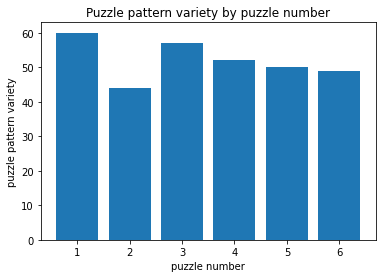

In [ ]:
# Print each puzzle numbers variety of pattern types
pattern_count=[]
for puzzle_number in range (0,puzzle_num_count):
    pattern_count.append(len(set(pattern_classified[puzzle_number])))
    print("Puzzle",puzzle_number+1,"has",pattern_count[puzzle_number],"patterns")

plt.bar(range(1,puzzle_num_count+1),pattern_count)
plt.xlabel("puzzle number")
plt.ylabel("puzzle pattern variety")
plt.title("Puzzle pattern variety by puzzle number")
plt.show()

In [ ]:
# Similarity Matrix

similarity_matrix=[]
for cursor_select in range (puzzle_num_count):
    similarity_row=[]
    for cursor_compare in range (puzzle_num_count):
        similarity_row.append(len(set(pattern_classified[cursor_select])&set(pattern_classified[cursor_compare])))
    similarity_matrix.append(similarity_row)

print("Similarity Matrix \n")
print(np.array(similarity_matrix))

Similarity Matrix 

[[60 33 41 42 37 36]
 [33 44 34 25 27 26]
 [41 34 57 37 37 36]
 [42 25 37 52 30 27]
 [37 27 37 30 50 31]
 [36 26 36 27 31 49]]


In [ ]:
# Check most complicated puzzle clear

most_complicated=Path_finder(pattern_type_x[pattern_clear_y.index(max(pattern_clear_y))])
print(most_complicated)

[[[3, 9, 6], [2, 5, 8], ['B', 4, 7]], [[3, 9, 6], ['B', 5, 8], [2, 4, 7]], [[3, 9, 6], [5, 'B', 8], [2, 4, 7]], [[3, 9, 6], [5, 8, 'B'], [2, 4, 7]], [[3, 9, 'B'], [5, 8, 6], [2, 4, 7]], [[3, 'B', 9], [5, 8, 6], [2, 4, 7]], [['B', 3, 9], [5, 8, 6], [2, 4, 7]], [[5, 3, 9], ['B', 8, 6], [2, 4, 7]], [[5, 3, 9], [8, 'B', 6], [2, 4, 7]], [[5, 'B', 9], [8, 3, 6], [2, 4, 7]], [[5, 9, 'B'], [8, 3, 6], [2, 4, 7]], [[5, 9, 6], [8, 3, 'B'], [2, 4, 7]], [[5, 9, 6], [8, 'B', 3], [2, 4, 7]], [[5, 9, 6], [8, 4, 3], [2, 'B', 7]], [[5, 9, 6], [8, 4, 3], [2, 7, 'B']], [[5, 9, 6], [8, 4, 'B'], [2, 7, 3]], [[5, 9, 'B'], [8, 4, 6], [2, 7, 3]], [[5, 'B', 9], [8, 4, 6], [2, 7, 3]], [['B', 5, 9], [8, 4, 6], [2, 7, 3]], [[8, 5, 9], ['B', 4, 6], [2, 7, 3]], [[8, 5, 9], [4, 'B', 6], [2, 7, 3]], [[8, 5, 9], [4, 7, 6], [2, 'B', 3]], [[8, 5, 9], [4, 7, 6], ['B', 2, 3]], [[8, 5, 9], ['B', 7, 6], [4, 2, 3]], [[8, 5, 9], [7, 'B', 6], [4, 2, 3]], [[8, 'B', 9], [7, 5, 6], [4, 2, 3]], [['B', 8, 9], [7, 5, 6], [4, 2, 3]], 

In [ ]:
# Print as np.array for visability

for puzzle in range(len(most_complicated)):
  print("Step",puzzle)
  print(np.array(most_complicated[puzzle]),"\n")

Step 0
[['3' '9' '6']
 ['2' '5' '8']
 ['B' '4' '7']] 

Step 1
[['3' '9' '6']
 ['B' '5' '8']
 ['2' '4' '7']] 

Step 2
[['3' '9' '6']
 ['5' 'B' '8']
 ['2' '4' '7']] 

Step 3
[['3' '9' '6']
 ['5' '8' 'B']
 ['2' '4' '7']] 

Step 4
[['3' '9' 'B']
 ['5' '8' '6']
 ['2' '4' '7']] 

Step 5
[['3' 'B' '9']
 ['5' '8' '6']
 ['2' '4' '7']] 

Step 6
[['B' '3' '9']
 ['5' '8' '6']
 ['2' '4' '7']] 

Step 7
[['5' '3' '9']
 ['B' '8' '6']
 ['2' '4' '7']] 

Step 8
[['5' '3' '9']
 ['8' 'B' '6']
 ['2' '4' '7']] 

Step 9
[['5' 'B' '9']
 ['8' '3' '6']
 ['2' '4' '7']] 

Step 10
[['5' '9' 'B']
 ['8' '3' '6']
 ['2' '4' '7']] 

Step 11
[['5' '9' '6']
 ['8' '3' 'B']
 ['2' '4' '7']] 

Step 12
[['5' '9' '6']
 ['8' 'B' '3']
 ['2' '4' '7']] 

Step 13
[['5' '9' '6']
 ['8' '4' '3']
 ['2' 'B' '7']] 

Step 14
[['5' '9' '6']
 ['8' '4' '3']
 ['2' '7' 'B']] 

Step 15
[['5' '9' '6']
 ['8' '4' 'B']
 ['2' '7' '3']] 

Step 16
[['5' '9' 'B']
 ['8' '4' '6']
 ['2' '7' '3']] 

Step 17
[['5' 'B' '9']
 ['8' '4' '6']
 ['2' '7' '3']] 

St